In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [33]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('dataset/training/cleaned/*.txt'))

import unicodedata
import string

import torch
import torch.nn as nn

import random

['dataset/training/cleaned\\yes.txt', 'dataset/training/cleaned\\no.txt']


In [34]:
len(string.ascii_letters)

52

In [35]:
len('com.tencent.angel.ml.core.conf.MLConf.ML_BATCH_SAMPLE_RATIO()__XX__com.tencent.angel.ml.core.conf.AngelMLConf.ML_GBDT_SAMPLE_RATIO()')

132

In [36]:
all_letters = string.ascii_letters + " .,;'"
# n_letters = 200
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in all_letters
#     )
    return s

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
category_lines_val = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('dataset/training/cleaned/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

for filename in findFiles('dataset/validation/cleaned/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    # all_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines

n_categories = len(all_categories)

In [37]:
len(all_letters)

57

In [38]:
all_categories

['yes', 'no']

In [39]:
print(category_lines['yes'][:5])

['sshd.SshServer.setForwardingFilter(ForwardingFilter)sshd.common.helpers.AbstractFactoryManager.setForwardingFilter(ForwardingFilter)', 'service.ServiceRegistryBuilder.buildServiceRegistry()boot.registry.StandardServiceRegistryBuilder.build()', 'metrics.core.MeterMetric.mark()metrics.core.Meter.mark()', 'sshd.SshServer.setUpDefaultServer()sshd.server.SshServer.setUpDefaultServer()', 'common.io.Resources.newInputStreamSupplier(URL)common.io.Resources.asByteSource(URL)']


In [40]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [41]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128
n_hidden = n_letters
rnn = RNN(n_letters, n_hidden, n_categories)

In [42]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# print(categoryFromOutput(output))

In [43]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomValidationExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = yes / line = common.io.ByteStreams.newInputStreamSupplier(byte[])common.io.ByteSource.wrap(byte[])
category = no / line = angel.ml.core.conf.MLConf.ML_RANK_NUM()angel.ml.core.conf.AngelMLConf.ML_NUM_TREE()
category = yes / line = Matchers.anyChar()ArgumentMatchers.anyChar()
category = no / line = ws.client.qualitygate.ProjectStatusWsRequest.setAnalysisId(String)ws.client.qualitygates.SelectRequest.setGateId()
category = no / line = node.NodeBuilder.settings()node.Node.start()
category = yes / line = catalina.deploy.FilterDef.setFilterClass(String)tomcat.util.descriptor.web.FilterDef.setFilterClass(String)
category = no / line = Matchers.eq(byte)ArgumentMatchers.eq(long)
category = no / line = action.mlt.MoreLikeThisRequestBuilder.setMaxDocFreq(int)index.query.MoreLikeThisQueryBuilder.minTermFreq()
category = yes / line = angel.ml.core.conf.MLConf.ML_RANK_NUM()angel.ml.core.conf.AngelMLConf.ML_RANK_NUM()
category = no / line = Matchers.anyList()ArgumentMatchers.anyFloat()


In [44]:
criterion = nn.NLLLoss()

In [45]:
learning_rate = 0.002 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [46]:
import time
import math

n_iters = 20000
print_every = 500
plot_every = 100

In [47]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.7f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 2% (0m 8s) 0.6511738 angel.ml.core.conf.MLConf.ML_LEARN_RATE()angel.ml.core.conf.AngelMLConf.DEFAULT_ML_LEARN_RATE() / no ✓
1000 5% (0m 16s) 0.6349214 common.base.Objects.toStringHelper(Object)common.base.CharMatcher.toString() / no ✓
1500 7% (0m 25s) 0.6911851 angel.ml.core.conf.MLConf.ML_MODEL_TYPE()angel.ml.core.conf.AngelMLConf.ML_MODEL_TYPE() / yes ✓
2000 10% (0m 33s) 0.7676868 dockerjava.api.model.ContainerConfig.isStdinOpen()dockerjava.api.model.ContainerConfig.getStdinOpen() / no ✗ (yes)
2500 12% (0m 42s) 0.5895810 angel.ml.core.conf.MLConf.ML_LEARN_RATE()angel.ml.core.conf.AngelMLConf.ML_RANK_NUM() / no ✓
3000 15% (0m 50s) 0.5800642 service.ServiceRegistryBuilder.applySettings(Map)boot.registry.StandardServiceRegistryBuilder.disableAutoClose() / no ✓
3500 17% (0m 58s) 0.6197856 Matchers.anyList()ArgumentMatchers.any() / no ✓
4000 20% (1m 5s) 0.7383062 jsqlparser.statement.select.SetOperationList.getPlainSelects()jsqlparser.statement.select.SetOperationList.getSelects() / n

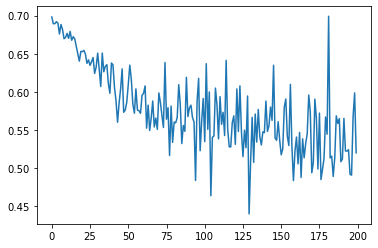

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\mgwei\AppData\Local\Temp/ipykernel_13096/2524513795.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\mgwei\AppData\Local\Temp/ipykernel_13096/2524513795.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


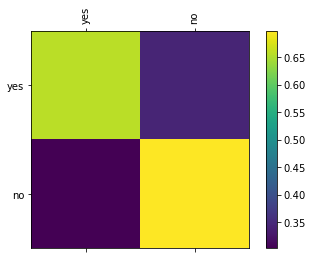

In [50]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 500

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomValidationExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
